# Solar Orbiter frame analysis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from construct import *

import collections

Open frames decoded with GNU Radio (see `handson_09_turbo_decode.grc`).

In [2]:
frame_size = 1115
frames = np.fromfile('frames.u8', dtype = 'uint8')
frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
print('We have', frames.shape[0], 'frames')

We have 1656 frames


First we check the frames' CRC-16. The CRC used in CCSDS TM Space Data Link frames is
CRC16_CCITT_FALSE from [this calculator](http://www.sunshine2k.de/coding/javascript/crc/crc_js.html).

In [3]:
crc_table = [0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50a5, 0x60c6, 0x70e7,
    0x8108, 0x9129, 0xa14a, 0xb16b, 0xc18c, 0xd1ad, 0xe1ce, 0xf1ef,
    0x1231, 0x0210, 0x3273, 0x2252, 0x52b5, 0x4294, 0x72f7, 0x62d6,
    0x9339, 0x8318, 0xb37b, 0xa35a, 0xd3bd, 0xc39c, 0xf3ff, 0xe3de,
    0x2462, 0x3443, 0x0420, 0x1401, 0x64e6, 0x74c7, 0x44a4, 0x5485,
    0xa56a, 0xb54b, 0x8528, 0x9509, 0xe5ee, 0xf5cf, 0xc5ac, 0xd58d,
    0x3653, 0x2672, 0x1611, 0x0630, 0x76d7, 0x66f6, 0x5695, 0x46b4,
    0xb75b, 0xa77a, 0x9719, 0x8738, 0xf7df, 0xe7fe, 0xd79d, 0xc7bc,
    0x48c4, 0x58e5, 0x6886, 0x78a7, 0x0840, 0x1861, 0x2802, 0x3823,
    0xc9cc, 0xd9ed, 0xe98e, 0xf9af, 0x8948, 0x9969, 0xa90a, 0xb92b,
    0x5af5, 0x4ad4, 0x7ab7, 0x6a96, 0x1a71, 0x0a50, 0x3a33, 0x2a12,
    0xdbfd, 0xcbdc, 0xfbbf, 0xeb9e, 0x9b79, 0x8b58, 0xbb3b, 0xab1a,
    0x6ca6, 0x7c87, 0x4ce4, 0x5cc5, 0x2c22, 0x3c03, 0x0c60, 0x1c41,
    0xedae, 0xfd8f, 0xcdec, 0xddcd, 0xad2a, 0xbd0b, 0x8d68, 0x9d49,
    0x7e97, 0x6eb6, 0x5ed5, 0x4ef4, 0x3e13, 0x2e32, 0x1e51, 0x0e70,
    0xff9f, 0xefbe, 0xdfdd, 0xcffc, 0xbf1b, 0xaf3a, 0x9f59, 0x8f78,
    0x9188, 0x81a9, 0xb1ca, 0xa1eb, 0xd10c, 0xc12d, 0xf14e, 0xe16f,
    0x1080, 0x00a1, 0x30c2, 0x20e3, 0x5004, 0x4025, 0x7046, 0x6067,
    0x83b9, 0x9398, 0xa3fb, 0xb3da, 0xc33d, 0xd31c, 0xe37f, 0xf35e,
    0x02b1, 0x1290, 0x22f3, 0x32d2, 0x4235, 0x5214, 0x6277, 0x7256,
    0xb5ea, 0xa5cb, 0x95a8, 0x8589, 0xf56e, 0xe54f, 0xd52c, 0xc50d,
    0x34e2, 0x24c3, 0x14a0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405,
    0xa7db, 0xb7fa, 0x8799, 0x97b8, 0xe75f, 0xf77e, 0xc71d, 0xd73c,
    0x26d3, 0x36f2, 0x0691, 0x16b0, 0x6657, 0x7676, 0x4615, 0x5634,
    0xd94c, 0xc96d, 0xf90e, 0xe92f, 0x99c8, 0x89e9, 0xb98a, 0xa9ab,
    0x5844, 0x4865, 0x7806, 0x6827, 0x18c0, 0x08e1, 0x3882, 0x28a3,
    0xcb7d, 0xdb5c, 0xeb3f, 0xfb1e, 0x8bf9, 0x9bd8, 0xabbb, 0xbb9a,
    0x4a75, 0x5a54, 0x6a37, 0x7a16, 0x0af1, 0x1ad0, 0x2ab3, 0x3a92,
    0xfd2e, 0xed0f, 0xdd6c, 0xcd4d, 0xbdaa, 0xad8b, 0x9de8, 0x8dc9,
    0x7c26, 0x6c07, 0x5c64, 0x4c45, 0x3ca2, 0x2c83, 0x1ce0, 0x0cc1,
    0xef1f, 0xff3e, 0xcf5d, 0xdf7c, 0xaf9b, 0xbfba, 0x8fd9, 0x9ff8,
    0x6e17, 0x7e36, 0x4e55, 0x5e74, 0x2e93, 0x3eb2, 0x0ed1, 0x1ef0]

def crc16_ccitt_false(data):
    crc = 0xffff
    for d in data:
        tbl_idx = ((crc >> 8) ^ d) & 0xff
        crc = (crc_table[tbl_idx] ^ (crc << 8)) & 0xffff
    return crc & 0xffff

Check the CRC of each frame

In [4]:
crc_ok = np.array([crc16_ccitt_false(f) for f in frames]) == 0

In [5]:
print(np.sum(~crc_ok), 'frames have invalid CRC')

2 frames have invalid CRC


Show the data bytes as an image. Note the TM Space Data Link headers on the left edge and the CRC on the right edge.

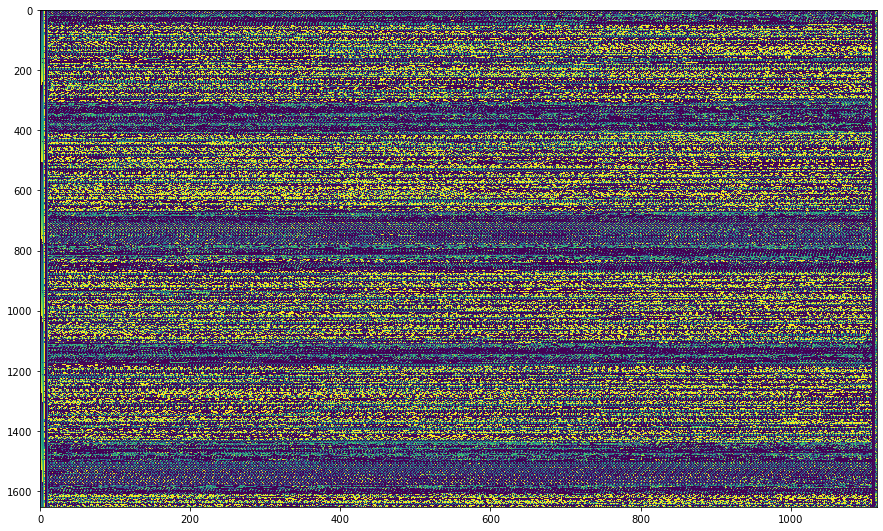

In [6]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames[crc_ok], interpolation = 'nearest', aspect = 0.4)

Parse TM Space Data Link primary headers using construct.

In [7]:
TMPrimaryHeader = BitStruct('transfer_frame_version_number' / BitsInteger(2),
                            'spacecraft_id' / BitsInteger(10),
                            'virtual_channel_id' / BitsInteger(3),
                            'ocf_flag' / Flag,
                            'master_channel_frame_count' / BitsInteger(8),
                            'virtual_channel_frame_count' / BitsInteger(8),
                            'transfer_frame_secondary_header_flag' / Flag,
                            'synch_flag' / Flag,
                            'packet_order' / Flag,
                            'segment_length_id' / BitsInteger(2),
                            'first_header_pointer' / BitsInteger(11))

primary_headers = [TMPrimaryHeader.parse(bytes(f)) for f in frames[crc_ok]]
mcfc = np.array([p.master_channel_frame_count for p in primary_headers])
vcid = np.array([p.virtual_channel_id for p in primary_headers])
vcfc = np.array([p.virtual_channel_frame_count for p in primary_headers])

Print the fields in the header of the first five frames.

In [8]:
for p in primary_headers[:5]:
    print(p)

Container: 
    transfer_frame_version_number = 0
    spacecraft_id = 650
    virtual_channel_id = 2
    ocf_flag = True
    master_channel_frame_count = 6
    virtual_channel_frame_count = 25
    transfer_frame_secondary_header_flag = True
    synch_flag = False
    packet_order = False
    segment_length_id = 3
    first_header_pointer = 2047
Container: 
    transfer_frame_version_number = 0
    spacecraft_id = 650
    virtual_channel_id = 2
    ocf_flag = True
    master_channel_frame_count = 7
    virtual_channel_frame_count = 26
    transfer_frame_secondary_header_flag = True
    synch_flag = False
    packet_order = False
    segment_length_id = 3
    first_header_pointer = 926
Container: 
    transfer_frame_version_number = 0
    spacecraft_id = 650
    virtual_channel_id = 2
    ocf_flag = True
    master_channel_frame_count = 8
    virtual_channel_frame_count = 27
    transfer_frame_secondary_header_flag = True
    synch_flag = False
    packet_order = False
    segment_length

Count the number of frames belonging to each virtual channel.

In [9]:
collections.Counter(vcid)

Counter({2: 1592, 0: 59, 4: 3})

Plot the master channel frame counter.

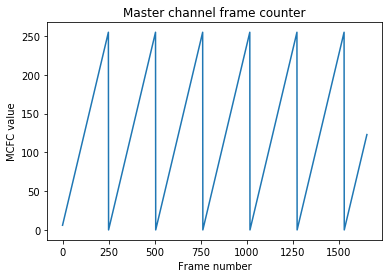

In [10]:
plt.plot(mcfc)
plt.title('Master channel frame counter')
plt.ylabel('MCFC value')
plt.xlabel('Frame number');

Use master channel frame counter to detect packet loss.

In [11]:
print('Packets lost:', np.sum(np.diff(mcfc.astype('uint8')) - 1))

Packets lost: 0
